# Urban Mobility Clustering

## README

### Running the notebook
To run the notebook you need to import the environment UrbanMobility.yml through Anaconda Navigator. Then select Kernel -> Change Kernel -> Python UrbanMobility. Once you have selected the kernel, you can compile and run the code by navigating to Kernel -> Restart Kernel and Run All Cells. It may take around 10 minutes for the whole notebook to compile, so please wait.

In [1]:
# imports
from __future__ import print_function
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

import glob
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import dask.dataframe as dd
import matplotlib.pyplot as plt
import openpyxl

from pandana.loaders import osm
from pandana.loaders.pandash5 import network_to_pandas_hdf5
import pandana as pdna
from shapely.geometry import Point
from shapely import wkt
import osmnx as ox
from random import sample
from tqdm import tqdm

import networkx as nx

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

import matplotlib.cm as cm
import matplotlib.colors as colors

from collections import deque

C:\Users\20232056\AppData\Local\anaconda3\envs\UrbanMobility\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
''' Use osmnx to get walkable street network for Eindhoven '''

# Speeds up loading data
ox.settings.use_cache = True
ox.settings.log_console = True 

# Creates the graph
G = ox.graph_from_place("Eindhoven, Netherlands", network_type = "walk")
G = ox.project_graph(G)

In [3]:
''' Loading amenity data '''

# Make sure data/Eindhoven.csv is in the same directory as this jupyter notebook
df = pd.read_csv("data/Eindhoven.csv", sep='|')
df['category'] = df['category'].astype(str)
df = df[df.category.str.isnumeric()==True]
df['category'] = df['category'].astype(float)
df = df.rename(columns={
    "name,": "name",
    "category": "poi_type_id",
    "osm_id": "amenity_id"
})

# Make sure data/poi_code_name_mapper.xlsx is in the same directory as this jupyter notebook
# poi type id matches the amenity column
poi_types = pd.read_excel("data/poi_code_name_mapper.xlsx")
poi_types = poi_types.replace(" ", np.nan).dropna()

df = df.merge(poi_types, on="poi_type_id")

df.head()

poi_type_id amenity_id        lat       lon  \
0         10.0     CUSTOM  51.444199  5.473112   
1         64.0  N42452978  51.356153  5.305949   
2         63.0  N42459812  51.359544  5.304001   
3         63.0  N42461335  51.359943  5.322896   
4         63.0  N42464939  51.361349  5.466640   

                                    name        amenity          category  
0  Salveo Pharma B.V., Medical Warehouse       pharmacy  health_wellbeing  
1                         Kortkruisdijk,       platform          mobility  
2                    Eersel, Postelseweg  stop_position          mobility  
3       Eersel, Monsigneur de Haasstraat  stop_position          mobility  
4               Valkenswaard, Merendreef  stop_position          mobility

In [4]:
''' Including demographic data '''

# Creates a GeoDataFrame from the df Data Frame, that is extends by the geometry component
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat)).set_crs(4326)

# Loads the demographic data
geo_uc = gpd.read_file("GHS_UCDB_THEME_GENERAL_CHARACTERISTICS_GLOBE_R2024A_V1_0/GHS_UCDB_THEME_GENERAL_CHARACTERISTICS_GLOBE_R2024A.gpkg", layer="GHS_UCDB_THEME_GENERAL_CHARACTERISTICS_GLOBE_R2024A")

geo_uc = geo_uc[["ID_UC_G0", "GC_CNT_GAD_2025", "GC_UCN_MAI_2025", "GC_POP_TOT_2025", "GC_UCA_KM2_2025", "geometry"]].dropna()
geo_uc["UC_NM_CTR"] = geo_uc["GC_UCN_MAI_2025"] + ", " +  geo_uc["GC_CNT_GAD_2025"]

# Filter to just Eindhoven
eindhoven_boundary = geo_uc[geo_uc["GC_UCN_MAI_2025"].str.contains("Eindhoven", case=False)]

# Reproject to match POI CRS
eindhoven_boundary = eindhoven_boundary.to_crs(gdf.crs)

# Keeps only rows from gdf that fall within Eindhoven's boundary geometry
gdf = gdf.sjoin(eindhoven_boundary, how="inner")

# Get the administrative boundary of Eindhoven (admin level 8 = municipality)
eindhoven_admin = ox.geocode_to_gdf("Eindhoven, Netherlands")
eindhoven_admin = eindhoven_admin.to_crs(gdf.crs)

# exclude any POIs that do not lie within the administrative borders of Eindhoven
# since bbbike Eindhoven extract is bounding-box based, not administratively clipped,
# they include everything that falls withing a rectangle that roughly contains Eindhoven
gdf = gdf[gdf.within(eindhoven_admin.union_all())]

df = gdf

df[['poi_type_id', 'amenity_id', 'lat', 'lon', 'name', 'amenity', 'category', 'geometry']].head()

poi_type_id amenity_id        lat       lon  \
0          10.0     CUSTOM  51.444199  5.473112   
28         20.0  N36723712  51.447810  5.487505   
51         64.0  N25294742  51.445874  5.492298   
65         64.0  N31493215  51.482846  5.450862   
66         64.0  N32575094  51.490576  5.451601   

                                     name   amenity          category  \
0   Salveo Pharma B.V., Medical Warehouse  pharmacy  health_wellbeing   
28                      Bibliotheek TU/e,   library   community_space   
51                 TU/e ingang De Wielen,  platform          mobility   
65                            Artoislaan,  platform          mobility   
66                          Castiliëlaan,  platform          mobility   

                    geometry  
0    POINT (5.47311 51.4442)  
28   POINT (5.4875 51.44781)  
51   POINT (5.4923 51.44587)  
65  POINT (5.45086 51.48285)  
66   POINT (5.4516 51.49058)

In [5]:
''' Filtering Out Regions Without Any POIs per km2 '''

# make df of ratio poi/pop to filter data
df["count"] = 1
df_poi_per_pop = df.groupby(["ID_UC_G0", "UC_NM_CTR"]).agg({"GC_POP_TOT_2025":"mean", "count":"sum", "GC_UCA_KM2_2025":"mean"}).reset_index()
df_poi_per_pop["poi_per_pop"] = df_poi_per_pop["count"]/df_poi_per_pop["GC_POP_TOT_2025"]
df_poi_per_pop["poi_per_km2"] = df_poi_per_pop["count"]/df_poi_per_pop["GC_UCA_KM2_2025"]

# list of urban centers to keep (at least 1 POI per km2)
uc_keep = df_poi_per_pop[(df_poi_per_pop.poi_per_km2>=1)&(df_poi_per_pop["count"]>=20)].ID_UC_G0.to_list()
df_keep = df[df['ID_UC_G0'].isin(uc_keep)]

df_keep = df_keep.drop(columns=["count"])

df_keep.head()

poi_type_id amenity_id        lat       lon  \
0          10.0     CUSTOM  51.444199  5.473112   
28         20.0  N36723712  51.447810  5.487505   
51         64.0  N25294742  51.445874  5.492298   
65         64.0  N31493215  51.482846  5.450862   
66         64.0  N32575094  51.490576  5.451601   

                                     name   amenity          category  \
0   Salveo Pharma B.V., Medical Warehouse  pharmacy  health_wellbeing   
28                      Bibliotheek TU/e,   library   community_space   
51                 TU/e ingang De Wielen,  platform          mobility   
65                            Artoislaan,  platform          mobility   
66                          Castiliëlaan,  platform          mobility   

                    geometry  index_right  ID_UC_G0 GC_CNT_GAD_2025  \
0    POINT (5.47311 51.4442)         2564      2627     Netherlands   
28   POINT (5.4875 51.44781)         2564      2627     Netherlands   
51   POINT (5.4923 51.44587)         2564      2627     Netherlands   
65  POINT (5.45086 51.48285)         2564      2627     Netherlands   
66   POINT (5.4516 51.49058)         2564      2627     Netherlands   

   GC_UCN_MAI_2025  GC_POP_TOT_2025  GC_UCA_KM2_2025               UC_NM_CTR  
0        Eindhoven      293437.7853               98  Eindhoven, Netherlands  
28       Eindhoven      293437.7853               98  Eindhoven, Netherlands  
51       Eindhoven      293437.7853               98  Eindhoven, Netherlands  
65       Eindhoven      293437.7853               98  Eindhoven, Netherlands  
66       Eindhoven      293437.7853               98  Eindhoven, Netherlands

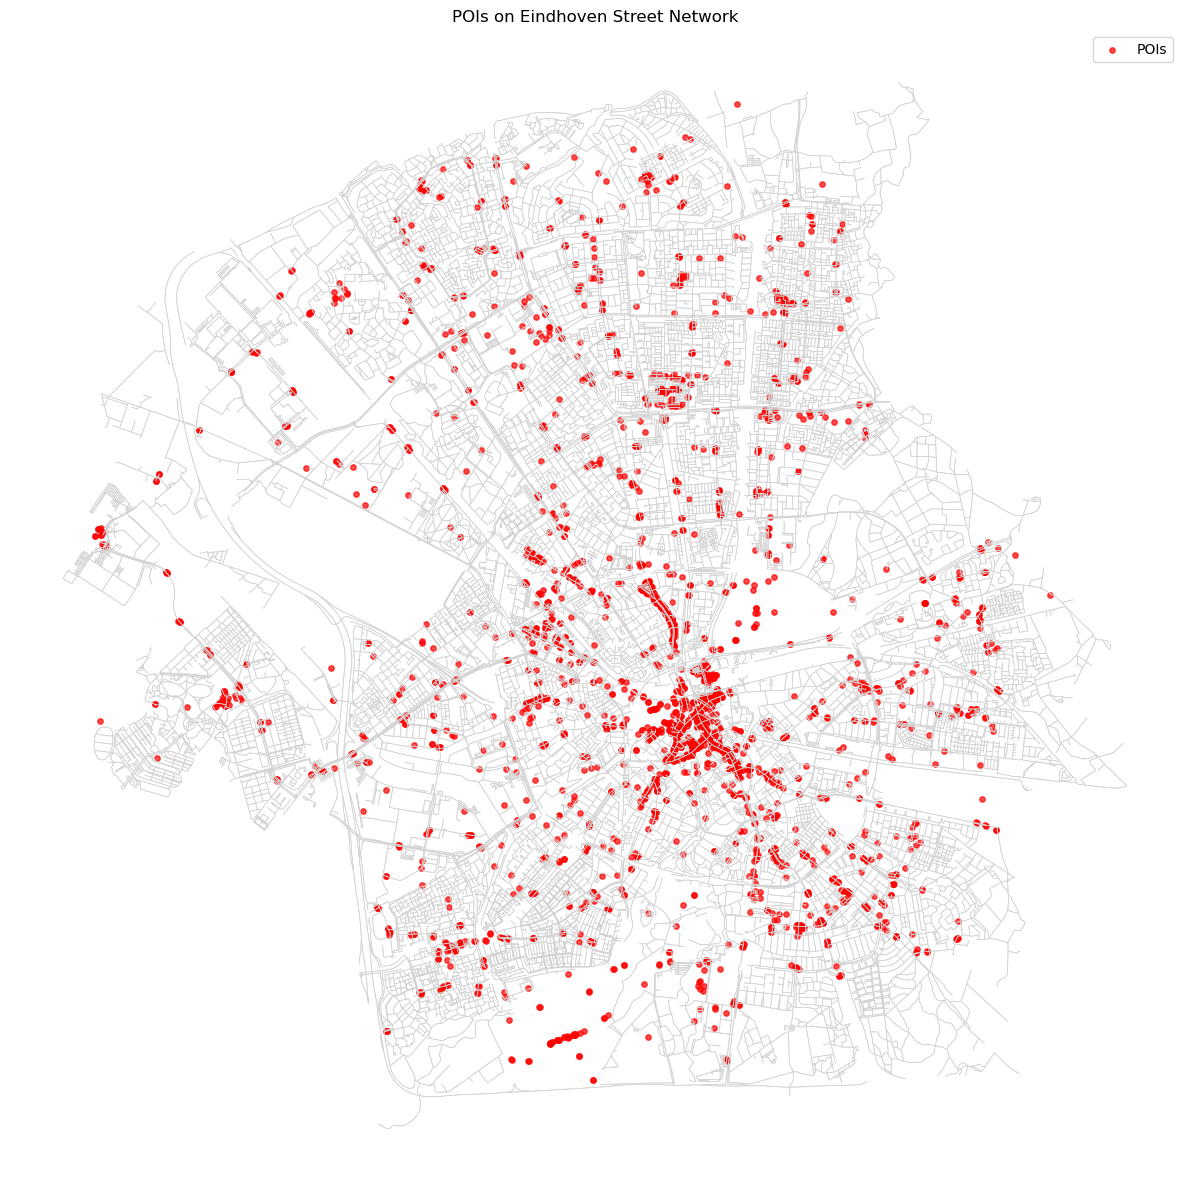

In [6]:
''' Visualizes POIs (amenities) on Eindhoven Street Network '''
gdf_nodes, gdf_edges = ox.convert.graph_to_gdfs(G, nodes = True, edges = True, node_geometry = True, fill_edge_geometry = True) 

# Projects POI dataframe (df) to match graph CRS
gdf = gpd.GeoDataFrame(df_keep, geometry=gpd.points_from_xy(df_keep.lon, df_keep.lat), crs="EPSG:4326")
gdf = gdf.to_crs(gdf_edges.crs)

# Plot everything
fig, ax = plt.subplots(figsize=(12, 12))

# Plot street edges
gdf_edges.plot(ax=ax, linewidth=0.5, edgecolor="lightgray")

# Plot POIs
gdf.plot(ax=ax, color='red', markersize=15, alpha=0.7, label='POIs')

# Styling
plt.title("POIs on Eindhoven Street Network")
plt.axis("off")
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
''' Creating Walkable Eindhoven Network '''

# splits G into two gdf: nodes (intersections, dead ends) and edges (street segments)
gdf_nodes, gdf_edges = ox.convert.graph_to_gdfs(G, nodes = True, edges = True, node_geometry = True, fill_edge_geometry = True) 

gdf_nodes = gdf_nodes.reset_index()
gdf_edges = gdf_edges.reset_index()

gdf_nodes['osmid'] = gdf_nodes['osmid'].astype(np.int64)
gdf_nodes['x'] = gdf_nodes['x'].astype(np.float64)
gdf_nodes['y'] = gdf_nodes['y'].astype(np.float64)

gdf_edges['u'] = gdf_edges['u'].astype(np.int64)
gdf_edges['v'] = gdf_edges['v'].astype(np.int64)
gdf_edges['length'] = gdf_edges['length'].astype(np.float64)

gdf_edges = gdf_edges[gdf_edges['u'].isin(gdf_nodes['osmid']) & gdf_edges['v'].isin(gdf_nodes['osmid'])]

gdf_nodes.set_index('osmid', inplace = True)

# Creating custom Pandana Network from the nodes and edges extracted from the Eindhoven graph G
# IMPORTANT: to run, downgrade numpy to 1.23.5
net = pdna.Network(
    gdf_nodes['x'],
    gdf_nodes['y'],
    gdf_edges['u'],
    gdf_edges['v'],
    gdf_edges[['length']]
)

# Precomputes the reachable nodes from each node within the maximum distance of 1500 meters
net.precompute(1500)

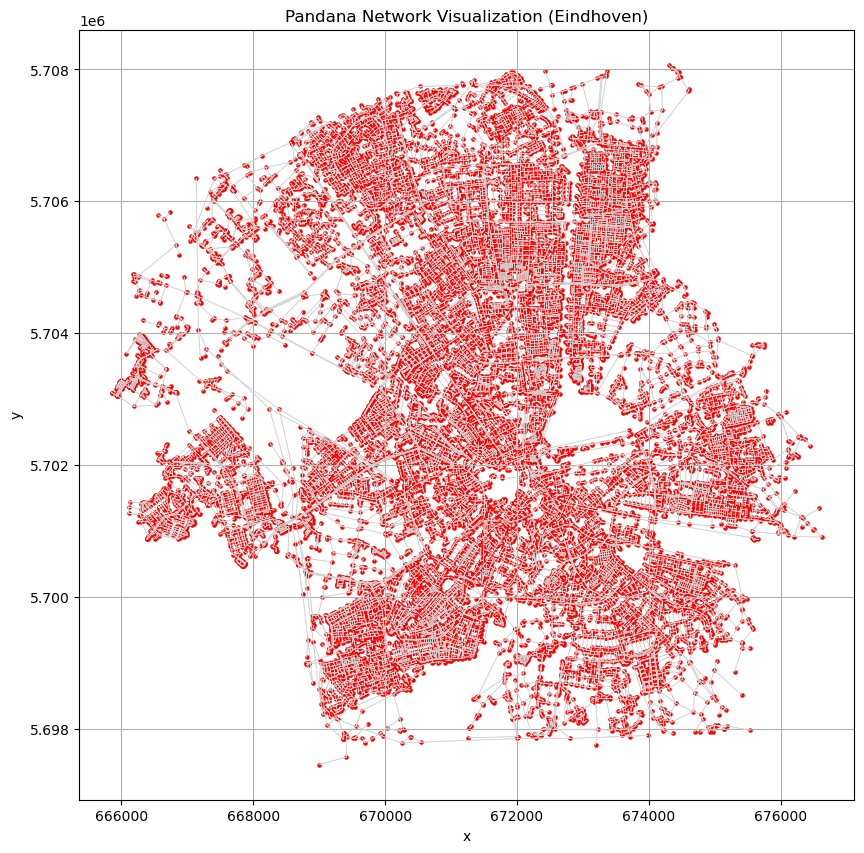

In [8]:
''' Basic Network Plot From gdf_nodes And gdf_edges '''

fig, ax = plt.subplots(figsize=(10, 10))

# Plot edges as lines
for _, edge in gdf_edges.iterrows():
    u = edge['u']
    v = edge['v']
    x0, y0 = gdf_nodes.loc[u, 'x'], gdf_nodes.loc[u, 'y']
    x1, y1 = gdf_nodes.loc[v, 'x'], gdf_nodes.loc[v, 'y']
    ax.plot([x0, x1], [y0, y1], color='lightgray', linewidth=0.5)

# Plot nodes as points
ax.scatter(gdf_nodes['x'], gdf_nodes['y'], c='red', s=5, label='nodes')

ax.set_title("Pandana Network Visualization (Eindhoven)")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.axis("equal")
plt.grid(True)
plt.show()

In [9]:
''' Relating POIs to Network (associating to each amenity its closest node (intersection/dead end)) '''

# Projects POIs to match the street network
df_keep = df_keep.to_crs(gdf_nodes.crs)

# Extracts projected x/y
df_keep["x_proj"] = df_keep.geometry.x
df_keep["y_proj"] = df_keep.geometry.y

# Uses projected coordinates for the closest node lookup
df_keep["node_ids"] = net.get_node_ids(df_keep["x_proj"], df_keep["y_proj"])

# df_keep[node_ids] - id of the closest node to that amenity, can be repeated for different amenities
df_keep[["poi_type_id", "amenity_id", "lat", "lon", "name", "amenity", "category", "geometry", "node_ids"]].head()
#df_keep.head()

poi_type_id amenity_id        lat       lon  \
0          10.0     CUSTOM  51.444199  5.473112   
28         20.0  N36723712  51.447810  5.487505   
51         64.0  N25294742  51.445874  5.492298   
65         64.0  N31493215  51.482846  5.450862   
66         64.0  N32575094  51.490576  5.451601   

                                     name   amenity          category  \
0   Salveo Pharma B.V., Medical Warehouse  pharmacy  health_wellbeing   
28                      Bibliotheek TU/e,   library   community_space   
51                 TU/e ingang De Wielen,  platform          mobility   
65                            Artoislaan,  platform          mobility   
66                          Castiliëlaan,  platform          mobility   

                          geometry     node_ids  
0   POINT (671863.183 5702124.732)  11829067224  
28  POINT (672849.575 5702560.144)   9999910010  
51  POINT (673189.921 5702356.229)   9999909965  
65   POINT (670173.277 5706369.94)     42751474  
66  POINT (670195.781 5707231.148)   5504169717

In [10]:
''' Creating a Dataframe Specifying for Each Network Node Which Amenity Categories Are Reachable From It in 15-Minute Walk '''

df_poi_cat = df_keep[["node_ids", "category"]].drop_duplicates()

poi_dummy = pd.get_dummies(df_poi_cat["category"])
df_poi_cat = df_poi_cat.join(poi_dummy).drop("category", axis=1)
df_poi_cat = df_poi_cat.groupby("node_ids").sum().reset_index()

print(df_poi_cat.size)
df_poi_cat.head()

10264


node_ids  active_living  community_space  education  food_choices  \
0  25547663              0                0          0             0   
1  32582116              0                0          0             0   
2  33530663              1                0          0             0   
3  33531010              0                0          0             0   
4  42567062              0                0          0             0   

   health_wellbeing  mobility  nightlife  
0                 0         1          0  
1                 0         1          0  
2                 0         0          0  
3                 0         1          0  
4                 1         0          0

In [11]:
''' Extracting Network Nodes Coordinates '''

gdf_nodes = gdf_nodes.reset_index()

coords = gdf_nodes[gdf_nodes["osmid"].isin(df_poi_cat["node_ids"])]
X = coords[["x", "y"]].values

# coords[osmid] - id of the node
coords.head()

osmid             y              x  street_count highway  ref  \
3      42642687  5.702180e+06  672279.974097             1     NaN  NaN   
29     25547663  5.703035e+06  674554.623329             1     NaN  NaN   
106    42580601  5.699474e+06  673349.091498             4     NaN  NaN   
121    42580621  5.699479e+06  673441.983902             4     NaN  NaN   
167  3882669677  5.699818e+06  673695.593141             4     NaN  NaN   

    railway junction                        geometry  
3       NaN      NaN   POINT (672279.974 5702179.58)  
29      NaN      NaN  POINT (674554.623 5703034.948)  
106     NaN      NaN  POINT (673349.091 5699474.383)  
121     NaN      NaN  POINT (673441.984 5699478.971)  
167     NaN      NaN  POINT (673695.593 5699817.927)

In [12]:
print(f"Number of POI network nodes used in clustering: {X.shape[0]}")
print(f"Number of POI network nodes used in df_keep:", df_keep["node_ids"].nunique())

Number of POI network nodes used in clustering: 1283
Number of POI network nodes used in df_keep: 1283


In [13]:
''' Using Hierarchical Clustering of Nodes With Distance Threshold ~1500 Meters '''

clustering = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=1500,
    linkage='complete'
).fit(X)

coords = coords.copy()
coords["cluster"] = clustering.labels_

print(coords.shape[0])

coords.head()

1283


osmid             y              x  street_count highway  ref  \
3      42642687  5.702180e+06  672279.974097             1     NaN  NaN   
29     25547663  5.703035e+06  674554.623329             1     NaN  NaN   
106    42580601  5.699474e+06  673349.091498             4     NaN  NaN   
121    42580621  5.699479e+06  673441.983902             4     NaN  NaN   
167  3882669677  5.699818e+06  673695.593141             4     NaN  NaN   

    railway junction                        geometry  cluster  
3       NaN      NaN   POINT (672279.974 5702179.58)        1  
29      NaN      NaN  POINT (674554.623 5703034.948)       49  
106     NaN      NaN  POINT (673349.091 5699474.383)       12  
121     NaN      NaN  POINT (673441.984 5699478.971)       12  
167     NaN      NaN  POINT (673695.593 5699817.927)       12

In [14]:
''' Merging Cluster Info Back With POIs '''

poi_clustered = df_keep.merge(coords[["osmid", "cluster"]], left_on="node_ids", right_on="osmid")

poi_clustered = poi_clustered.drop(columns=["osmid"])

# IMPORTANT
# poi_clustered[amenity_id] - id of the specific amenity (NOT the id of the type of the amenity)
# poi_clustered[node_ids] - id of the closest node to that amenity, can be repeated for different amenities

print(poi_clustered.shape[0])
poi_clustered[["poi_type_id", "amenity_id", "lat", "lon", "name", "amenity", "category", "geometry", "node_ids", "cluster"]].head()
#poi_clustered.head()

2595


poi_type_id amenity_id        lat       lon  \
0         10.0     CUSTOM  51.444199  5.473112   
1         20.0  N36723712  51.447810  5.487505   
2         64.0  N25294742  51.445874  5.492298   
3         64.0  N31493215  51.482846  5.450862   
4         64.0  N32575094  51.490576  5.451601   

                                    name   amenity          category  \
0  Salveo Pharma B.V., Medical Warehouse  pharmacy  health_wellbeing   
1                      Bibliotheek TU/e,   library   community_space   
2                 TU/e ingang De Wielen,  platform          mobility   
3                            Artoislaan,  platform          mobility   
4                          Castiliëlaan,  platform          mobility   

                         geometry     node_ids  cluster  
0  POINT (671863.183 5702124.732)  11829067224       31  
1  POINT (672849.575 5702560.144)   9999910010       31  
2  POINT (673189.921 5702356.229)   9999909965       22  
3   POINT (670173.277 5706369.94)     42751474       15  
4  POINT (670195.781 5707231.148)   5504169717       15

In [15]:
''' Counting Category Coverage per Cluster '''

cluster_coverage = poi_clustered.groupby("cluster")["category"].nunique().reset_index(name="poi_category_count")

#naming each cluster
cluster_names = {
    0: "Irisbuurt",
    1: "Centrum",
    3: "Woensel Zuid",
    4: "Vaartbroek",
    8: "Evoluon",
    9: "Putten",
    10: "Strijp S",
    12: "Nieuwe Erven",
    13: "Vlokhoven",
    15: "Achtse Barrier",
    16: "Gestel",
    17: "Doornakkers",
    18: "Limbeek",
    19: "Schouwbroek",
    20: "Tuindorp",
    21: "Meerrijk",
    23: "Eckart",
    25: "Genderdal",
    28: "Gijzenrooi",
    31: "TU/E + North Centrum",
    33: "Tempel",
    44: "High Tech Campus",
    46: "Rochusbuurt",
    49: "'t Hofke",
}

cluster_coverage["cluster_name"] = cluster_coverage["cluster"].map(cluster_names)

print(cluster_coverage.shape[0])
cluster_coverage.head(6)

52


cluster  poi_category_count  cluster_name
0        0                   7     Irisbuurt
1        1                   6       Centrum
2        2                   5           NaN
3        3                   6  Woensel Zuid
4        4                   7    Vaartbroek
5        5                   5           NaN

In [16]:
''' Filtering Clusters With at least N Unique POI Types (e.g., 6 types) '''

valid_clusters = cluster_coverage[cluster_coverage["poi_category_count"] >= 6]

print(valid_clusters.shape[0])
valid_clusters.head()

23


cluster  poi_category_count  cluster_name
0        0                   7     Irisbuurt
1        1                   6       Centrum
3        3                   6  Woensel Zuid
4        4                   7    Vaartbroek
8        8                   6       Evoluon

In [17]:
''' Filtering POIs to Only Those in Valid Clusters '''

filtered_pois = poi_clustered[poi_clustered["cluster"].isin(valid_clusters["cluster"])]

filtered_pois.to_csv("poi_clusters_data.csv", index=False)

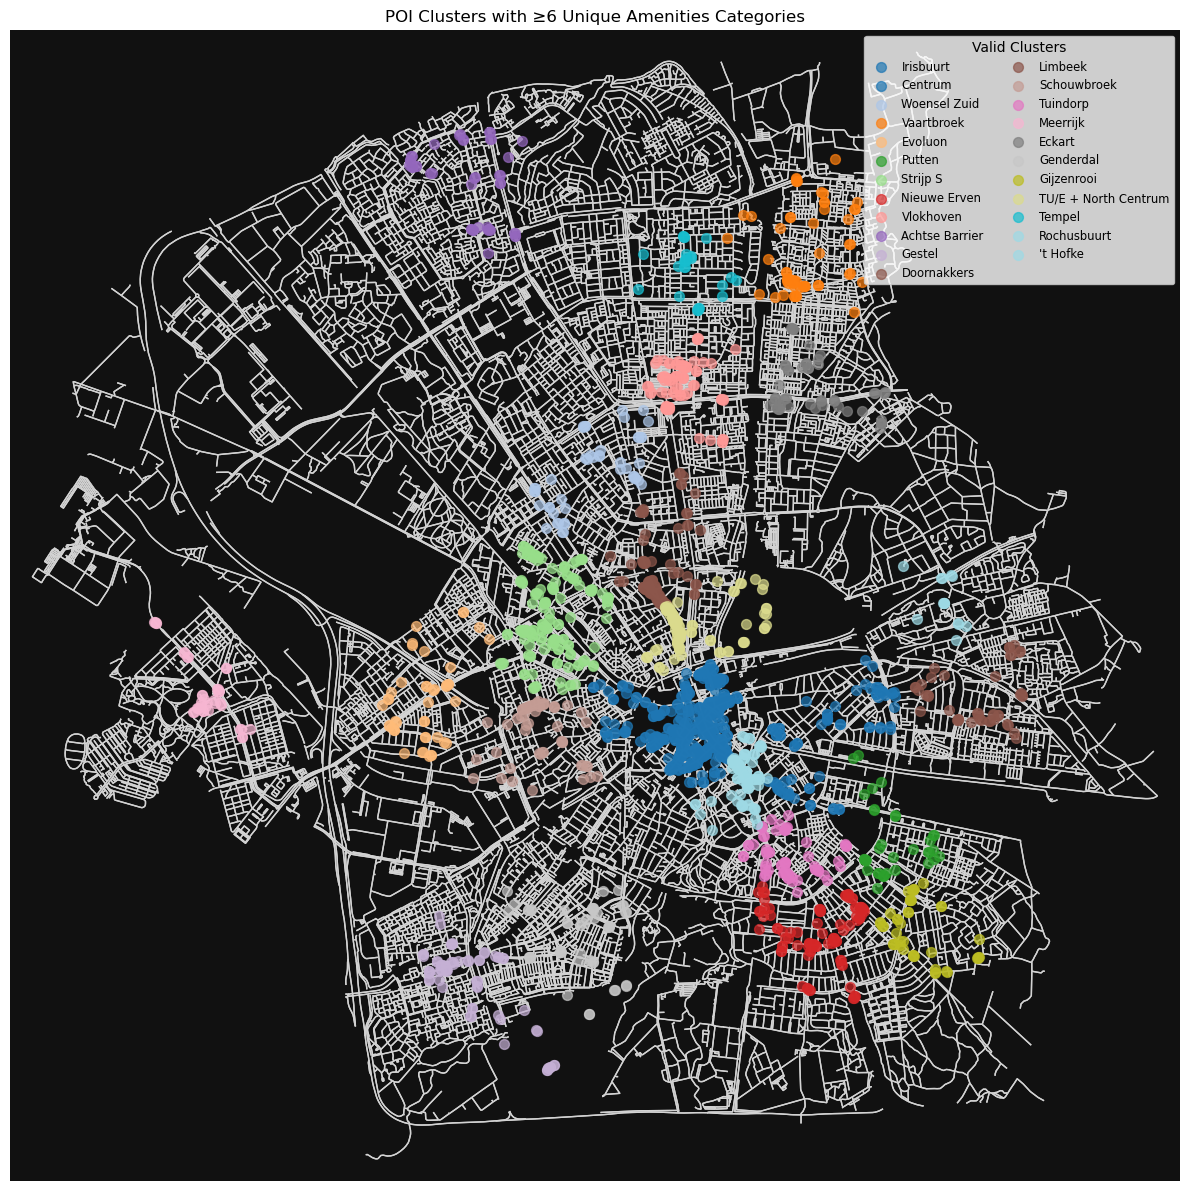

In [18]:
''' Visualizing the Clusters '''
# Step 1: Filter POIs to only those in valid clusters
filtered_pois = poi_clustered[poi_clustered["cluster"].isin(valid_clusters["cluster"])]

# Step 2: Plot street network
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='lightgray', node_size=0)

# Step 3: Setup colormap
unique_clusters = sorted(filtered_pois["cluster"].unique())
norm = colors.Normalize(vmin=min(unique_clusters), vmax=max(unique_clusters))
cmap = plt.get_cmap('tab20', len(unique_clusters))

# Step 4: Plot each cluster
for i, cluster_id in enumerate(unique_clusters):
    group = filtered_pois[filtered_pois["cluster"] == cluster_id]
    ax.scatter(
        group["geometry"].x, 
        group["geometry"].y, 
        s=50, 
        color=cmap(i), 
        label=cluster_names[cluster_id],
        alpha=0.7
    )
fig.set_size_inches(12, 12)

# Optional: add legend
ax.legend(title="Valid Clusters", fontsize='small', loc='upper right', ncol=2)
plt.title("POI Clusters with ≥6 Unique Amenities Categories")
plt.tight_layout()


plt.savefig("poi_clusters_vis.png")

plt.show()

In [19]:
''' Finding All Health and Wellbeing Locations In the Chosen Clusters And Putting Them Into a Dataframe '''

df_healthlocs = poi_clustered[poi_clustered["category"] == "health_wellbeing"]
df_healthlocs.head(50)
df_healthlocs = df_healthlocs[
    (df_healthlocs["cluster"].isin([4, 12, 13])) |
    (df_healthlocs["name"] == "Salveo Pharma B.V., Medical Warehouse")
]

df_healthlocs

poi_type_id    amenity_id        lat       lon  \
0            10.0        CUSTOM  51.444199  5.473112   
90           10.0    N501975668  51.471014  5.473745   
638          10.0   N2734155728  51.476130  5.490281   
648          14.0   N2734015127  51.482687  5.500808   
673           8.0   N2739349378  51.421499  5.485146   
681           7.0   N2739431386  51.420125  5.495227   
716          10.0   N2740383705  51.424018  5.497548   
838          10.0   N2751971191  51.470963  5.474490   
2173         10.0   N9824565340  51.420138  5.494685   
2277          7.0  N11955510811  51.425185  5.485756   
2300          7.0  N12204938781  51.421266  5.488283   

                                       name     amenity          category  \
0     Salveo Pharma B.V., Medical Warehouse    pharmacy  health_wellbeing   
90                    Apotheek SGE Woensel,    pharmacy  health_wellbeing   
638                      Apotheek Lingmont,    pharmacy  health_wellbeing   
648      Dierenartsenpraktijk Heesterakker,  veterinary  health_wellbeing   
673             Medisch Centrum Aalsterweg,     doctors  health_wellbeing   
681                         Dental Clinics,     dentist  health_wellbeing   
716                       Apotheek Arnouts,    pharmacy  health_wellbeing   
838                            SGE Woensel,    pharmacy  health_wellbeing   
2173                   Apotheek de Roosten,    pharmacy  health_wellbeing   
2277                        Tandartsenpost,     dentist  health_wellbeing   
2300   Tandartspraktijk van de Vondervoort,     dentist  health_wellbeing   

                            geometry  index_right  ID_UC_G0 GC_CNT_GAD_2025  \
0     POINT (671863.183 5702124.732)         2564      2627     Netherlands   
90    POINT (671806.403 5705107.795)         2564      2627     Netherlands   
638     POINT (672935.323 5705715.6)         2564      2627     Netherlands   
648   POINT (673641.348 5706469.512)         2564      2627     Netherlands   
673   POINT (672784.957 5699629.044)         2564      2627     Netherlands   
681   POINT (673490.984 5699500.176)         2564      2627     Netherlands   
716   POINT (673637.602 5699938.444)         2564      2627     Netherlands   
838   POINT (671858.332 5705103.806)         2564      2627     Netherlands   
2173  POINT (673453.285 5699500.283)         2564      2627     Netherlands   
2277  POINT (672813.446 5700040.325)         2564      2627     Netherlands   
2300  POINT (673003.912 5699610.564)         2564      2627     Netherlands   

     GC_UCN_MAI_2025  GC_POP_TOT_2025  GC_UCA_KM2_2025  \
0          Eindhoven      293437.7853               98   
90         Eindhoven      293437.7853               98   
638        Eindhoven      293437.7853               98   
648        Eindhoven      293437.7853               98   
673        Eindhoven      293437.7853               98   
681        Eindhoven      293437.7853               98   
716        Eindhoven      293437.7853               98   
838        Eindhoven      293437.7853               98   
2173       Eindhoven      293437.7853               98   
2277       Eindhoven      293437.7853               98   
2300       Eindhoven      293437.7853               98   

                   UC_NM_CTR         x_proj        y_proj     node_ids  \
0     Eindhoven, Netherlands  671863.182594  5.702125e+06  11829067224   
90    Eindhoven, Netherlands  671806.403173  5.705108e+06  12222992590   
638   Eindhoven, Netherlands  672935.323460  5.705716e+06     42729976   
648   Eindhoven, Netherlands  673641.347802  5.706470e+06   6292188212   
673   Eindhoven, Netherlands  672784.956820  5.699629e+06     42584765   
681   Eindhoven, Netherlands  673490.983992  5.699500e+06   5229033738   
716   Eindhoven, Netherlands  673637.602391  5.699938e+06     42591500   
838   Eindhoven, Netherlands  671858.331644  5.705104e+06    501940433   
2173  Eindhoven, Netherlands  673453.284953  5.699500e+06     42580621   
2277  Eindhoven, Nethe

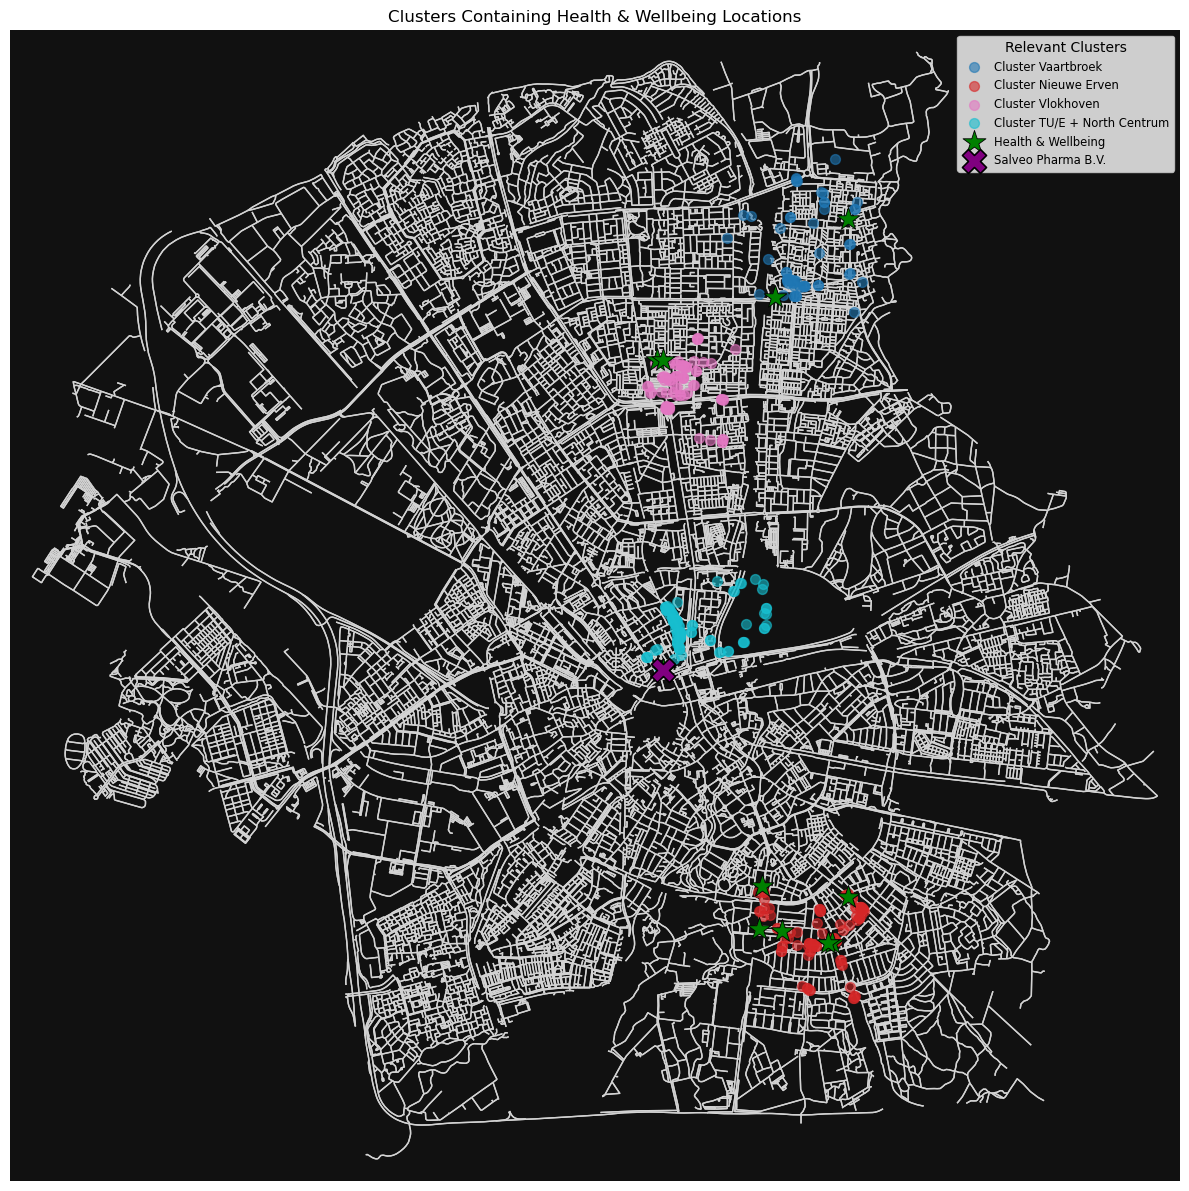

In [20]:
''' Ploting the Chosen Clusters with Health and Wellbeing Locations '''

# Get unique clusters these health locations belong to
health_clusters = df_healthlocs["cluster"].unique()

# Filter only those clusters from full POI dataset
filtered_health_pois = poi_clustered[poi_clustered["cluster"].isin(health_clusters)]

# Plot
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='lightgray', node_size=0)

# Set up colormap
unique_clusters = sorted(filtered_health_pois["cluster"].unique())
cmap = plt.get_cmap('tab10', len(unique_clusters))

# Plot the clusters these health locations belong to
for i, cluster_id in enumerate(unique_clusters):
    group = filtered_health_pois[filtered_health_pois["cluster"] == cluster_id]
    ax.scatter(
        group["geometry"].x,
        group["geometry"].y,
        s=50,
        color=cmap(i),
        label=f"Cluster {cluster_names[cluster_id]}",
        alpha=0.6
    )

# Plot the actual health & wellbeing locations
ax.scatter(
    df_healthlocs["geometry"].x,
    df_healthlocs["geometry"].y,
    s=300,
    color="green",
    marker="*",
    label="Health & Wellbeing",
    edgecolor="black",
    linewidth=0.6,
    zorder=10
)

highlighted_loc = df_healthlocs.loc[0]

ax.scatter(
    highlighted_loc.geometry.x,
    highlighted_loc.geometry.y,
    s=300,
    color="purple",             
    marker="X",              
    label="Salveo Pharma B.V.",
    edgecolor="black",
    linewidth=1.2,
    zorder=11
)

fig.set_size_inches(12, 12)
ax.legend(title="Relevant Clusters", fontsize='small', loc='upper right')
plt.title("Clusters Containing Health & Wellbeing Locations")
plt.tight_layout()
plt.savefig("relevant_clusters_with_health.png")
plt.show()

In [21]:
''' Identifying Coordinates for Routing '''

# Ensure geometry is set correctly
df_healthlocs["geometry"] = df_healthlocs.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)
gdf_healthlocs = gpd.GeoDataFrame(df_healthlocs, geometry="geometry", crs="EPSG:4326")
gdf_healthlocs = gdf_healthlocs.to_crs(epsg=28992)  # Convert to meters for distance calculation

all_points = list(gdf_healthlocs.geometry)

gdf_healthlocs

poi_type_id    amenity_id        lat       lon  \
0            10.0        CUSTOM  51.444199  5.473112   
90           10.0    N501975668  51.471014  5.473745   
638          10.0   N2734155728  51.476130  5.490281   
648          14.0   N2734015127  51.482687  5.500808   
673           8.0   N2739349378  51.421499  5.485146   
681           7.0   N2739431386  51.420125  5.495227   
716          10.0   N2740383705  51.424018  5.497548   
838          10.0   N2751971191  51.470963  5.474490   
2173         10.0   N9824565340  51.420138  5.494685   
2277          7.0  N11955510811  51.425185  5.485756   
2300          7.0  N12204938781  51.421266  5.488283   

                                       name     amenity          category  \
0     Salveo Pharma B.V., Medical Warehouse    pharmacy  health_wellbeing   
90                    Apotheek SGE Woensel,    pharmacy  health_wellbeing   
638                      Apotheek Lingmont,    pharmacy  health_wellbeing   
648      Dierenartsenpraktijk Heesterakker,  veterinary  health_wellbeing   
673             Medisch Centrum Aalsterweg,     doctors  health_wellbeing   
681                         Dental Clinics,     dentist  health_wellbeing   
716                       Apotheek Arnouts,    pharmacy  health_wellbeing   
838                            SGE Woensel,    pharmacy  health_wellbeing   
2173                   Apotheek de Roosten,    pharmacy  health_wellbeing   
2277                        Tandartsenpost,     dentist  health_wellbeing   
2300   Tandartspraktijk van de Vondervoort,     dentist  health_wellbeing   

                           geometry  index_right  ID_UC_G0 GC_CNT_GAD_2025  \
0     POINT (160972.702 383904.165)         2564      2627     Netherlands   
90     POINT (161013.147 386887.45)         2564      2627     Netherlands   
638   POINT (162161.254 387458.131)         2564      2627     Netherlands   
648   POINT (162891.458 388188.616)         2564      2627     Netherlands   
673   POINT (161812.689 381379.813)         2564      2627     Netherlands   
681   POINT (162514.134 381228.024)         2564      2627     Netherlands   
716   POINT (162674.944 381661.277)         2564      2627     Netherlands   
838   POINT (161064.917 386881.771)         2564      2627     Netherlands   
2173   POINT (162476.46 381229.359)         2564      2627     Netherlands   
2277  POINT (161854.557 381789.941)         2564      2627     Netherlands   
2300  POINT (162030.924 381354.212)         2564      2627     Netherlands   

     GC_UCN_MAI_2025  GC_POP_TOT_2025  GC_UCA_KM2_2025  \
0          Eindhoven      293437.7853               98   
90         Eindhoven      293437.7853               98   
638        Eindhoven      293437.7853               98   
648        Eindhoven      293437.7853               98   
673        Eindhoven      293437.7853               98   
681        Eindhoven      293437.7853               98   
716        Eindhoven      293437.7853               98   
838        Eindhoven      293437.7853               98   
2173       Eindhoven      293437.7853               98   
2277       Eindhoven      293437.7853               98   
2300       Eindhoven      293437.7853               98   

                   UC_NM_CTR         x_proj        y_proj     node_ids  \
0     Eindhoven, Netherlands  671863.182594  5.702125e+06  11829067224   
90    Eindhoven, Netherlands  671806.403173  5.705108e+06  12222992590   
638   Eindhoven, Netherlands  672935.323460  5.705716e+06     42729976   
648   Eindhoven, Netherlands  673641.347802  5.706470e+06   6292188212   
673   Eindhoven, Netherlands  672784.956820  5.699629e+06     42584765   
681   Eindhoven, Netherlands  673490.983992  5.699500e+06   5229033738   
716   Eindhoven, Netherlands  673637.602391  5.699938e+06     42591500   
838   Eindhoven, Netherlands  671858.331644  5.705104e+06    501940433   
2173  Eindhoven, Netherlands  673453.284953  5.699500e+06     42580621   
2277  Eindhoven, Netherlands  6728

# Routing

In [22]:
LOCATION_NAMES = {
    0: "Salveo Pharma B.V.",
    1: "Apotheek SGE Woensel",
    2: "Apotheek Lingmont",
    3: "Dierenartsenpraktijk Heesterakker",
    4: "Medisch Centrum Aalsterweg",
    5: "Dental Clinics",
    6: "Apotheek Arnouts",
    7: "SGE Woensel",
    8: "Apotheek de Roosten",
    9: "Tandartsenpost",
   10: "Tandartspraktijk van de Vondervoort",
}

In [23]:
''' Creating the Distance Matrix '''

n = len(all_points)
dist_matrix = np.zeros((n, n))

print("DISTANCE MATRIX:\n")

# Fill the distance matrix with pairwise distances between all points
for i in range(n):
    for j in range(n):
        dist_matrix[i][j] = int(round(all_points[i].distance(all_points[j])))

dist_matrix_df = pd.DataFrame(dist_matrix.astype(int))

dist_matrix_df

DISTANCE MATRIX:



0     1     2     3     4     5     6     7     8     9     10
0      0  2984  3747  4694  2660  3088  2816  2979  3069  2291  2761
1   2984     0  1282  2285  5565  5855  5484    52  5844  5166  5626
2   3747  1282     0  1033  6088  6240  5820  1239  6237  5676  6105
3   4694  2285  1033     0  6894  6971  6531  2246  6972  6482  6888
4   2660  5565  6088  6894     0   718   907  5553   681   412   220
5   3088  5855  6240  6971   718     0   462  5837    38   866   499
6   2816  5484  5820  6531   907   462     0  5463   475   830   713
7   2979    52  1239  2246  5553  5837  5463     0  5826  5153  5611
8   3069  5844  6237  6972   681    38   475  5826     0   837   463
9   2291  5166  5676  6482   412   866   830  5153   837     0   470
10  2761  5626  6105  6888   220   499   713  5611   463   470     0

In [24]:
''' Generating 2-day Pharmacies' Reuqest Log '''

import random

PRESCRIPTIONS = 750

def request_generator(num_locations=10):
    
    prescriptions_by_location = {loc: 0 for loc in range(1, num_locations + 1)}
    pharmacies = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    request_log = {"Pharmacy":[], "Request [g]":[]}
    
    while len(pharmacies)>0:
        loc = random.choice(pharmacies)  

        # Each pharmacy can request max 400 prescriptions total
        remaining = PRESCRIPTIONS - prescriptions_by_location[loc]
        if remaining <= 0:
            pharmacies.remove(loc)
            continue

        # This request tries to consume 1-remaining prescriptions (25g–10000g)
        if remaining <= 10: num_prescriptions = 10
        else: num_prescriptions = random.randint(10, remaining)
        
        payload_weight = num_prescriptions * 25  # in grams
        prescriptions_by_location[loc] += num_prescriptions

        request_log["Pharmacy"].append(loc)
        request_log["Request [g]"].append(payload_weight)
        #print("loc -", LOCATION_NAMES[loc], "; request -", payload_weight)

    df_request_log = pd.DataFrame.from_dict(request_log)
    df_request_log
    return df_request_log
        
df_request_log = request_generator()
grouped_df = df_request_log.groupby("Pharmacy", as_index=False)["Request [g]"].sum()
df_request_log = grouped_df.set_index("Pharmacy")

df_request_log.to_excel("2DayRequestLog.xlsx")
print('DataFrame is written to Excel File successfully.')

df_request_log

DataFrame is written to Excel File successfully.


Request [g]
Pharmacy             
1               18950
2               18775
3               18750
4               18875
5               18900
6               18750
7               18750
8               18975
9               18975
10              18900

In [25]:
''' Defining Drone Specification Used in the Simulation '''

drone_speed_mps = 20
drone_speed_mpm = drone_speed_mps * 60
drone_capacity = 30000 # grams
drone_range = 16000 #meters
branch_drop_halt_time = 15 
optimizer_run_time = 120

In [26]:
''' Preprocessing Request List '''

drop_demand_list = [0]
drop_distance = list()
drop_time_list = [0]

drop_distance_matrix = dist_matrix_df.copy()
drop_distance_matrix['0'] = 0

for index, row in df_request_log.iterrows():
    if(row["Request [g]"] == 0):
        drop_distance_matrix = drop_distance_matrix.drop(index)
        drop_distance_matrix = drop_distance_matrix.drop(index, axis = 1)
    else:
        drop_demand_list.append(row["Request [g]"])
        drop_time_list.append(branch_drop_halt_time)

for i in range(len(drop_distance_matrix)):
    l = (list(drop_distance_matrix.iloc[i]))
    drop_distance.append(l)

In [27]:
end_nodes = list()

In [28]:
starts = list()

def return_data_setup():
    ends = list()
    end_list = list()
    
    global end_nodes
    
    for item in end_nodes:
        if(item < len(dist_matrix_df)):
            starts.append(item)
            end_list.append(item)
        else:
            starts.append(0)
        
    cols = dist_matrix_df.columns
    for num in end_list:
        ends.append(cols[num])
    print(ends)

In [29]:
def create_data_model_drops():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = drop_distance
    data['demands'] = drop_demand_list
    data['times'] = drop_time_list
    data['vehicle_capacities'] = [drone_capacity]*10
    data['vehicle_ranges'] = drone_range*10
                                  
    data['num_vehicles'] = 10
    data['depot'] = 0
    return data

In [30]:
data = create_data_model_drops()

print("==== DATA SUMMARY ====\n")

print(f"Depot index: {data['depot']}")
print(f"Number of vehicles: {data['num_vehicles']}")
print(f"Vehicle capacities: {data['vehicle_capacities'][0]} (repeated {len(data['vehicle_capacities'])} times)\n")

print("Demands per location:")
for i, demand in enumerate(data['demands']):
    print(f"  Location {i}: {demand}")

print("\nService time per location:")
for i, t in enumerate(data['times']):
    print(f"  Location {i}: {t}")

print("\nDistance matrix:")
for i, row in enumerate(data['distance_matrix']):
    row_str = ' '.join([f"{val:5}" for val in row])
    print(f"  From {i}: {row_str}")

==== DATA SUMMARY ====

Depot index: 0
Number of vehicles: 10
Vehicle capacities: 30000 (repeated 10 times)

Demands per location:
  Location 0: 0
  Location 1: 18950
  Location 2: 18775
  Location 3: 18750
  Location 4: 18875
  Location 5: 18900
  Location 6: 18750
  Location 7: 18750
  Location 8: 18975
  Location 9: 18975
  Location 10: 18900

Service time per location:
  Location 0: 0
  Location 1: 15
  Location 2: 15
  Location 3: 15
  Location 4: 15
  Location 5: 15
  Location 6: 15
  Location 7: 15
  Location 8: 15
  Location 9: 15
  Location 10: 15

Distance matrix:
  From 0:     0  2984  3747  4694  2660  3088  2816  2979  3069  2291  2761     0
  From 1:  2984     0  1282  2285  5565  5855  5484    52  5844  5166  5626     0
  From 2:  3747  1282     0  1033  6088  6240  5820  1239  6237  5676  6105     0
  From 3:  4694  2285  1033     0  6894  6971  6531  2246  6972  6482  6888     0
  From 4:  2660  5565  6088  6894     0   718   907  5553   681   412   220     0
  From 5:

In [31]:
''' Responsible for Printing the Simulation Output '''

route_info = {}

def print_solution_drops(data, manager, routing, solution):
    """Prints solution on console."""
    total_distance = 0
    total_load = 0
    total_time = 0
    print("------- Forward Route - Drops -----------------\n")
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for trip {}:\n'.format(vehicle_id + 1)
        route_distance = 0
        route_load = 0
        route_time = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            plan_output += ' {0} {1} Load({2}) -> '.format(node_index, LOCATION_NAMES[node_index], route_load)
            previous_index = index
            if(routing.IsEnd(solution.Value(routing.NextVar(index)))):
                end_nodes.append(index)
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        route_time = round((route_distance-1000000)/drone_speed_mpm) + branch_drop_halt_time*2 # for the pharmacy and the warehouse 
        plan_output += ' {0} {1} Load({2})\n'.format(manager.IndexToNode(index), LOCATION_NAMES[manager.IndexToNode(index)],
                                                 route_load)
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}\n'.format(route_load)
        plan_output += 'Time of the route: {} min\n'.format(route_time)
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
        total_time += route_time
        
    print('Total distance of all routes: {}m'.format(total_distance))
    print('Total load of all routes: {}'.format(total_load))
    print('Total time of all routes: {}'.format(total_time))

In [32]:
''' Actual Simulation Logic - using Google OR-Tools '''

def main_drops():
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model_drops()
    print("main_drops called")
    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'],data['depot'])
    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)
    
    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return int(data['distance_matrix'][from_node][to_node])

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    
    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        data['vehicle_ranges'],
        True,  
        'Distance')
    
    #Defining Vehicle Addition cost
    for vehicle_id in range(data['num_vehicles']):
        routing.SetFixedCostOfVehicle(1000000, vehicle_id)
    
    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')
    
    def time_callback(from_index, to_index):
        num = 0
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        num = data['times'][from_node] + (data['distance_matrix'][from_node][to_node])/drone_speed_mpm
        return num
    time_callback_index = routing.RegisterTransitCallback(time_callback)
    routing.AddDimension(time_callback_index, 0, 285, True, 'Time')
    
     # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    search_parameters.time_limit.seconds = optimizer_run_time
    search_parameters.log_search = True
    print("search params set")
    solution = routing.SolveWithParameters(search_parameters)
    print("solution available")
    # Print solution on console.
    if solution:
        print_solution_drops(data, manager, routing, solution)

In [33]:
main_drops()
return_data_setup()

main_drops called
search params set
solution available
------- Forward Route - Drops -----------------

Route for trip 1:
 0 Salveo Pharma B.V. Load(0) ->  1 Apotheek SGE Woensel Load(18950) ->  0 Salveo Pharma B.V. Load(18950)
Distance of the route: 1005968m
Load of the route: 18950
Time of the route: 35 min

Route for trip 2:
 0 Salveo Pharma B.V. Load(0) ->  2 Apotheek Lingmont Load(18775) ->  0 Salveo Pharma B.V. Load(18775)
Distance of the route: 1007494m
Load of the route: 18775
Time of the route: 36 min

Route for trip 3:
 0 Salveo Pharma B.V. Load(0) ->  3 Dierenartsenpraktijk Heesterakker Load(18750) ->  0 Salveo Pharma B.V. Load(18750)
Distance of the route: 1004694m
Load of the route: 18750
Time of the route: 34 min

Route for trip 4:
 0 Salveo Pharma B.V. Load(0) ->  4 Medisch Centrum Aalsterweg Load(18875) ->  0 Salveo Pharma B.V. Load(18875)
Distance of the route: 1005320m
Load of the route: 18875
Time of the route: 34 min

Route for trip 5:
 0 Salveo Pharma B.V. Load(0) 

In [34]:
''' Determining the Delivery Schedule '''

# Define trips: (route_id, duration)
trips = [(8, 3), (4, 4), (9, 4), (1, 5), (5, 5), (6, 5), (7, 5), (10, 5), (2, 6), (3, 8)]
trip_durations = dict(trips)

all_trip_ids = list(trip_durations.keys())
executed_trips = []
unexecuted_trips = all_trip_ids

# Drone states
drones = [
    {'time': 0, 'id': 'Drone 1', 'available_at': 0},
]

# Results
schedule = []

for trip_id, duration in trips:
    # Sort drones by earliest available
    drones.sort(key=lambda d: d['available_at'])
    
    for drone in drones:
        if trip_id in executed_trips: continue
        if drone['time'] + duration <= 18:
            # Assign trip to this drone
            start_time = drone['available_at'] + branch_drop_halt_time
            end_time = start_time + duration + branch_drop_halt_time
            drone['time'] += duration
            executed_trips.append(trip_id)
            unexecuted_trip_ids = [tid for tid in all_trip_ids if tid not in executed_trips]

            if unexecuted_trip_ids:
                min_duration = min(trip_durations[tid] for tid in unexecuted_trip_ids)

            if drone['time'] + min_duration >= 18:
                schedule.append((drone['id'], trip_id, LOCATION_NAMES[trip_id], start_time, str(end_time) + " R"))
                drone['available_at'] = end_time + 26.5  # Recharge
                drone['time'] = 0
            else:
                schedule.append((drone['id'], trip_id, LOCATION_NAMES[trip_id], start_time, end_time))
                drone['available_at'] = end_time

df = pd.DataFrame(schedule, columns=['Drone', 'Trip ID', 'Delivered To', 'Start Time (min)', 'End Time (min)'])

# Optional: sort by start time
df = df.sort_values(by='Start Time (min)').reset_index(drop=True)

df

Drone  Trip ID                         Delivered To  Start Time (min)  \
0  Drone 1        8                  Apotheek de Roosten              15.0   
1  Drone 1        4           Medisch Centrum Aalsterweg              48.0   
2  Drone 1        9                       Tandartsenpost              82.0   
3  Drone 1        1                 Apotheek SGE Woensel             116.0   
4  Drone 1        5                       Dental Clinics             177.5   
5  Drone 1        6                     Apotheek Arnouts             212.5   
6  Drone 1        7                          SGE Woensel             247.5   
7  Drone 1       10  Tandartspraktijk van de Vondervoort             309.0   
8  Drone 1        2                    Apotheek Lingmont             344.0   
9  Drone 1        3    Dierenartsenpraktijk Heesterakker             406.5   

  End Time (min)  
0             33  
1             67  
2            101  
3          136 R  
4          197.5  
5          232.5  
6        267.5 R  
7          329.0  
8        365.0 R  
9          429.5

C:\Users\20232056\AppData\Local\Temp\ipykernel_23840\2177009197.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  line_cmap = cm.get_cmap('tab10', len(x_coords) - 1)


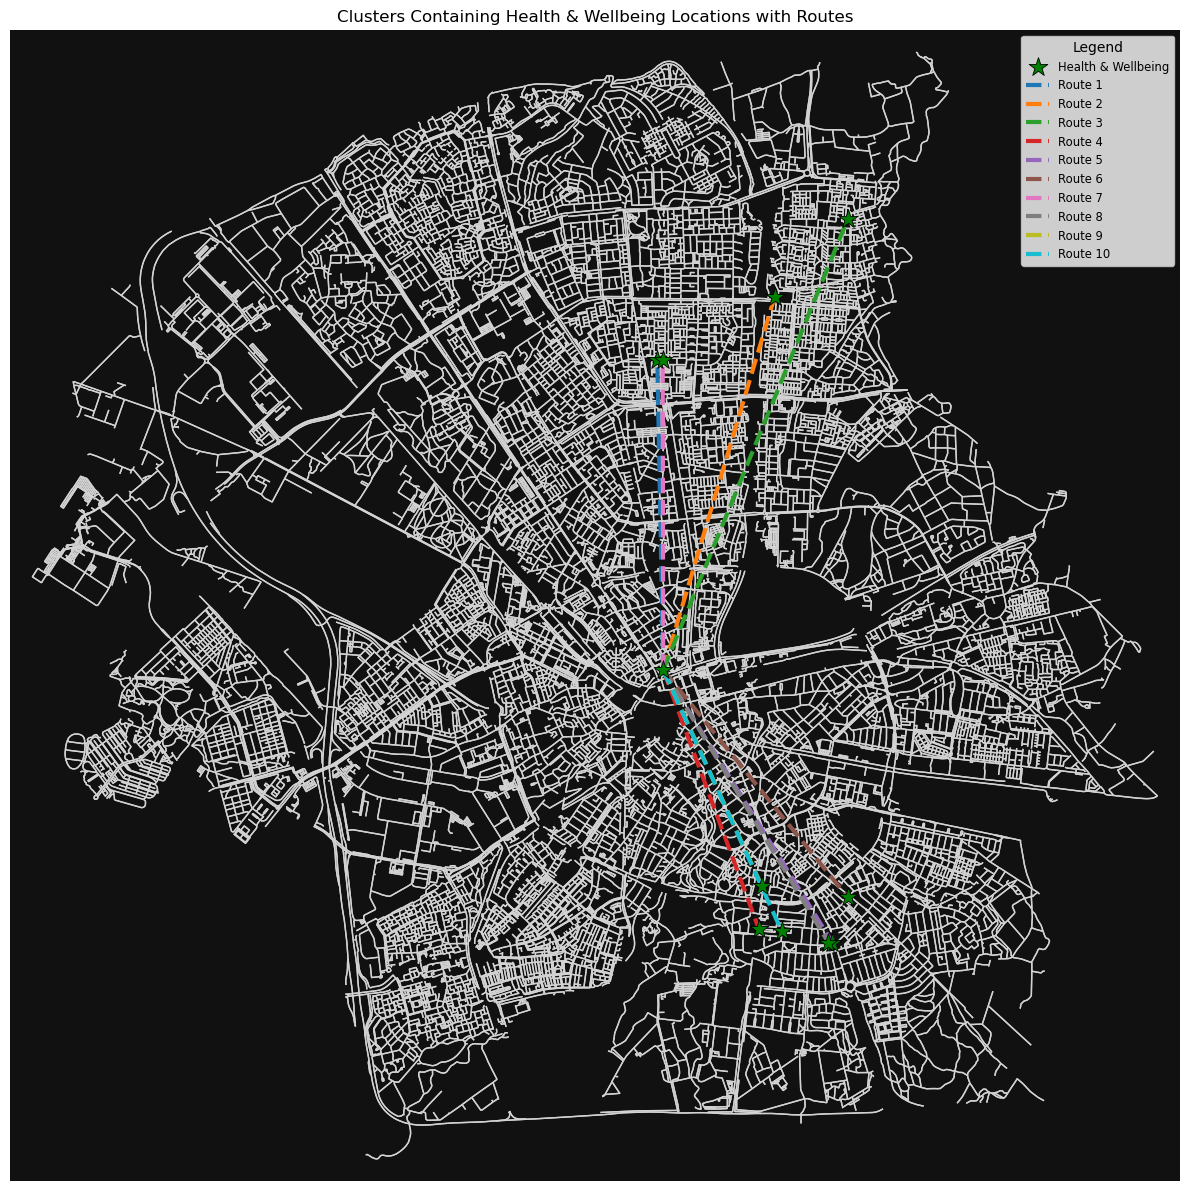

In [35]:
# Convert healthlocs to GeoDataFrame with correct CRS
df_healthlocs["geometry"] = df_healthlocs.apply(lambda r: Point(r["lon"], r["lat"]), axis=1)
gdf_healthlocs = gpd.GeoDataFrame(df_healthlocs, geometry="geometry", crs="EPSG:4326")
gdf_healthlocs = gdf_healthlocs.to_crs(G.graph['crs'])  # match graph CRS

fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='lightgray', node_size=0)

# Plot points in same CRS
ax.scatter(
    gdf_healthlocs.geometry.x,
    gdf_healthlocs.geometry.y,
    s=200,
    color="green",
    marker="*",
    label="Health & Wellbeing",
    edgecolor="black",
    linewidth=0.6,
    zorder=10
)

x_coords = gdf_healthlocs.geometry.x.tolist()
y_coords = gdf_healthlocs.geometry.y.tolist()

x_start, y_start = x_coords[0], y_coords[0]

line_cmap = cm.get_cmap('tab10', len(x_coords) - 1)

for i, (x, y) in enumerate(zip(x_coords[1:], y_coords[1:])):
    ax.plot([x_start, x], [y_start, y], color=line_cmap(i), linewidth=3, linestyle="--", label=f"Route {i+1}", zorder=5)

fig.set_size_inches(12, 12)
ax.legend(title="Legend", fontsize='small', loc='upper right')
plt.title("Clusters Containing Health & Wellbeing Locations with Routes")
plt.tight_layout()
plt.savefig("drone_routes_coloured.png")
plt.show()
